# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

In [3]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    plt.show()
    return


--2022-12-02 20:09:54--  https://perso.telecom-paristech.fr/anewson/doc/images/palma.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770583 (753K) [image/png]
Saving to: ‘palma.png’

palma.png           100%[===================>] 752.52K  1.60MB/s    in 0.5s    

2022-12-02 20:09:55 (1.60 MB/s) - ‘palma.png’ saved [770583/770583]



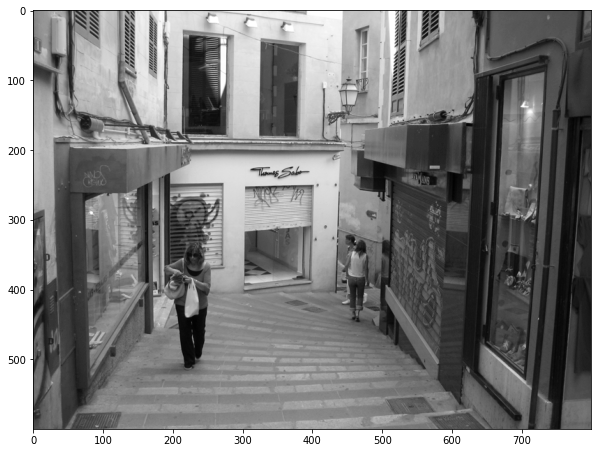

(600, 800)

In [4]:

file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
    img_gray,_ = read_image(file_name+file_ext)
else:
    img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixe values to the range $(0,1)$.

In [5]:

def add_gaussian_noise(img_in, sigma_noise = 0.01):
    gaussian_noise = np.random.normal(scale=sigma_noise, size=img_in.shape)
    img_out = img_in + gaussian_noise
    return img_out


def add_impulse_noise(img_in,p=0.9):
    def help_func(x):
        if np.random.rand() < p:
            return x
        elif np.random.rand() < 0.5:
            return 0
        else:
            return 1
    img_out = np.array(list(map(help_func, img_in.flatten()))).reshape(img_in.shape)
    return img_out

def add_missing_pixels_noise(img_in,p=0.9):
    def help_func(x):
        if np.random.rand() < p:
            return x
        else:
            return 0
    img_out = np.array(list(map(help_func, img_in.flatten()))).reshape(img_in.shape)
    return img_out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$ (the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [6]:
sigma_noise = 0.05
img_gray_gaussian = add_gaussian_noise(img_gray, sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

img_gray_impulse = add_impulse_noise(img_gray, p=0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')

img_gray_missing = add_missing_pixels_noise(img_gray, p=0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question 3.1__ For each type of noise, propose a restoration filter (see course slides) 

__Answer__:

- For the gaussian noise we can use smoothing filter
- For the impulse and missing noise we can use median filter

Implement these restoration techniques in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__Note__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented

In [7]:
from scipy import ndimage

def gaussian_filter(img, sigma = 3):
    img_out = ndimage.gaussian_filter(img, sigma)
    return img_out


def median_filter(img,median_size):
    img_out = ndimage.median_filter(img, median_size)
    return img_out

sigma_gauss = 1.0
img_out_gaussian = gaussian_filter(img_gray_gaussian,sigma_gauss)
write_image(img_out_gaussian,file_name+'_denoised_gaussian.png')

median_size = 10
img_out_impulse_median = median_filter(img_gray_impulse,median_size)
write_image(img_out_impulse_median,file_name+'_impulse_denoised_median.png')

img_out_missing_median = median_filter(img_gray_missing,median_size)
write_image(img_out_missing_median,file_name+'_missing_denoised_median.png')

__Question 3.2__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__:

- For the gaussian filter, choosing a bad parametere creates artefacts in the resulting image
- For the median filter, selecting a large kernel size produces an image that is blurry and without any sharp edges, while selecting a small kernel size results in an image that always contains noise .

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only__. 

In [8]:
np.sum((img_gray - img_out_gaussian)**2)

624.8904801361072

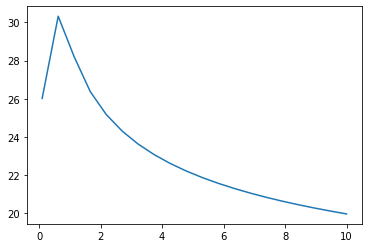

In [9]:
def PSNR(img, img_ref):
    mse = np.sum((img_ref - img)**2)/(img.shape[0] * img.shape[1])
    psnr = -10 * np.log10(mse)
    return psnr

psnr_results = []
sigma_values = np.linspace(0.1, 10, 20)
for sigma in sigma_values:
    img_out_gauss = gaussian_filter(img_gray_gaussian, sigma)
    psnr_results.append(PSNR(img_out_gauss, img_gray))
    
plt.plot(sigma_values, psnr_results)
plt.show()

- the higher PSNR generally indicates that the reconstruction is of higher quality. In our case the best sigma is $\sigma = 0.62$

## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


--2022-12-02 20:10:10--  https://perso.telecom-paristech.fr/anewson/doc/images/boston.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626414 (612K) [image/png]
Saving to: ‘boston.png’

boston.png          100%[===================>] 611.73K  1.64MB/s    in 0.4s    

2022-12-02 20:10:11 (1.64 MB/s) - ‘boston.png’ saved [626414/626414]



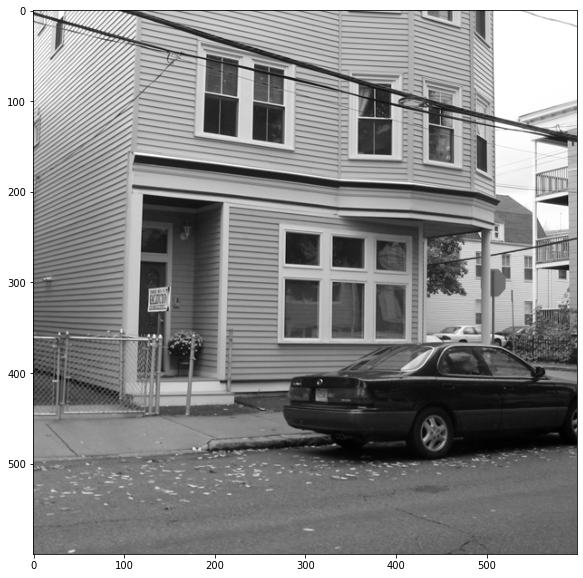

(600, 600)

In [10]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
    img_gray,_ = read_image(file_name+file_ext)
else:
    img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

(600, 600)


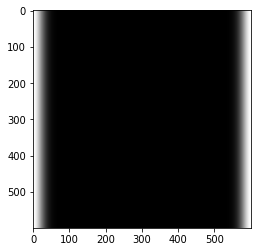

In [11]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ and write the result ``img_convolved`` to an output file


In [12]:
img_convolved = np.fft.fft2(img_gray) * f_hat

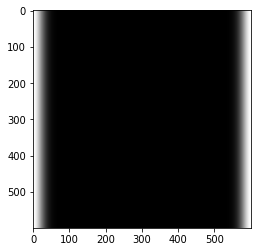

In [13]:
plt.imshow(f_hat,cmap='gray')
plt.show()

__Question 3.3__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ? How can this happen in real life ? 

__Answer__:

- this filter removes high frequencies in the y axis (gaussian filter in one direction).
- It happens in real life because objects move during the time it takes to expose the photo or the frame, and the movement gets recorded as a blur (motion blur)

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue (look at the formula at the beginning of this section on deconvolution).


In [14]:
def deconvolve_fourier(img, f_hat):
    #INSERT CODE HERE
    img_out = np.fft.ifft2(np.exp(np.log(img) - np.log(f_hat)))
    return img_out
    

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')